# 📊 Rolling Daily Cointegration Analysis - Currency Pairs

## GPU-Accelerated, 7-Day Rolling Window



This notebook visualizes the results of the GPU-optimized cointegration analysis computed **daily** on a rolling 7-day window. We use the Engle-Granger hBcstatistic (score) computed on the GPU to identify pairs that move together.



**Key Metrics:**

- **Score**: Engle-Granger hBcstatistic. Lower (more negative) values indicate stronger cointegration.

- **Significance**: Compared against MacKinnon critical values (e.g., -3.34 for 5% significance).

- **Rolling Analysis**: Relationships are tracked day-by-day using the last 7 days of data to capture short-term stability.


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
from datetime import datetime, timedelta
import pickle
import itertools

warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configuration matching the script
OUTPUT_DIR = Path("/mnt/ssd2/DARWINEX_Mission/results")
RESULTS_FILE = OUTPUT_DIR / "daily_cointegration_results_gpu.pkl"
WINDOW_DAYS = 7

# Critical values for Engle-Granger (2 variables, with constant)
CRIT_5PCT = -3.34
CRIT_1PCT = -3.90

print("\n✓ Environment configured successfully")


✓ Environment configured successfully


## 1️⃣ Load Results

Load the pre-computed results from the GPU analysis script.

In [2]:
if RESULTS_FILE.exists():
    print(f"\n✅ Loading results from: {RESULTS_FILE}")
    with open(RESULTS_FILE, 'rb') as f:
        daily_results = pickle.load(f)
    print(f"   ✓ Loaded {len(daily_results)} rolling days of analysis (window={WINDOW_DAYS}d)")
else:
    print(f"\n⚠️ Results file not found at: {RESULTS_FILE}")
    print(f"   Run the following command first:")
    print(f"   python /mnt/ssd2/DARWINEX_Mission/cointegration_analysis.py")
    daily_results = None


✅ Loading results from: /mnt/ssd2/DARWINEX_Mission/results/daily_cointegration_results_gpu.pkl
   ✓ Loaded 359 rolling days of analysis (window=7d)


## 2️⃣ Process Results into Matrices

Organize scores into weekly matrices for visualization.

In [3]:
if daily_results is not None:
    # Extract all unique pairs
    all_pairs_set = set()
    for day_data in daily_results:
        for result in day_data['results']:
            all_pairs_set.add(result['pair1'])
            all_pairs_set.add(result['pair2'])
    
    all_pairs_sorted = sorted(list(all_pairs_set))
    pair_to_idx = {p: i for i, p in enumerate(all_pairs_sorted)}
    
    print(f"📊 Analysis Summary:")
    print(f"   Days analyzed: {len(daily_results)}")
    print(f"   Unique assets: {len(all_pairs_sorted)}")
    
    daily_matrices = {}
    
    for day_data in daily_results:
        day_key = day_data['day']
        
        matrix = np.full((len(all_pairs_sorted), len(all_pairs_sorted)), np.nan)
        
        for result in day_data['results']:
            i, j = pair_to_idx[result['pair1']], pair_to_idx[result['pair2']]
            score = result['score']
            matrix[i, j] = score
            matrix[j, i] = score
        
        daily_matrices[day_key] = matrix
    
    print(f"✓ Data processed successfully")

📊 Analysis Summary:
   Days analyzed: 359
   Unique assets: 27
✓ Data processed successfully
✓ Data processed successfully


## 3️⃣ Cointegration Score Heatmaps

**Darker colors = Stronger Cointegration (More negative hBcstat)**. 
Red-dashed boundary indicates significance ( < -3.34$).

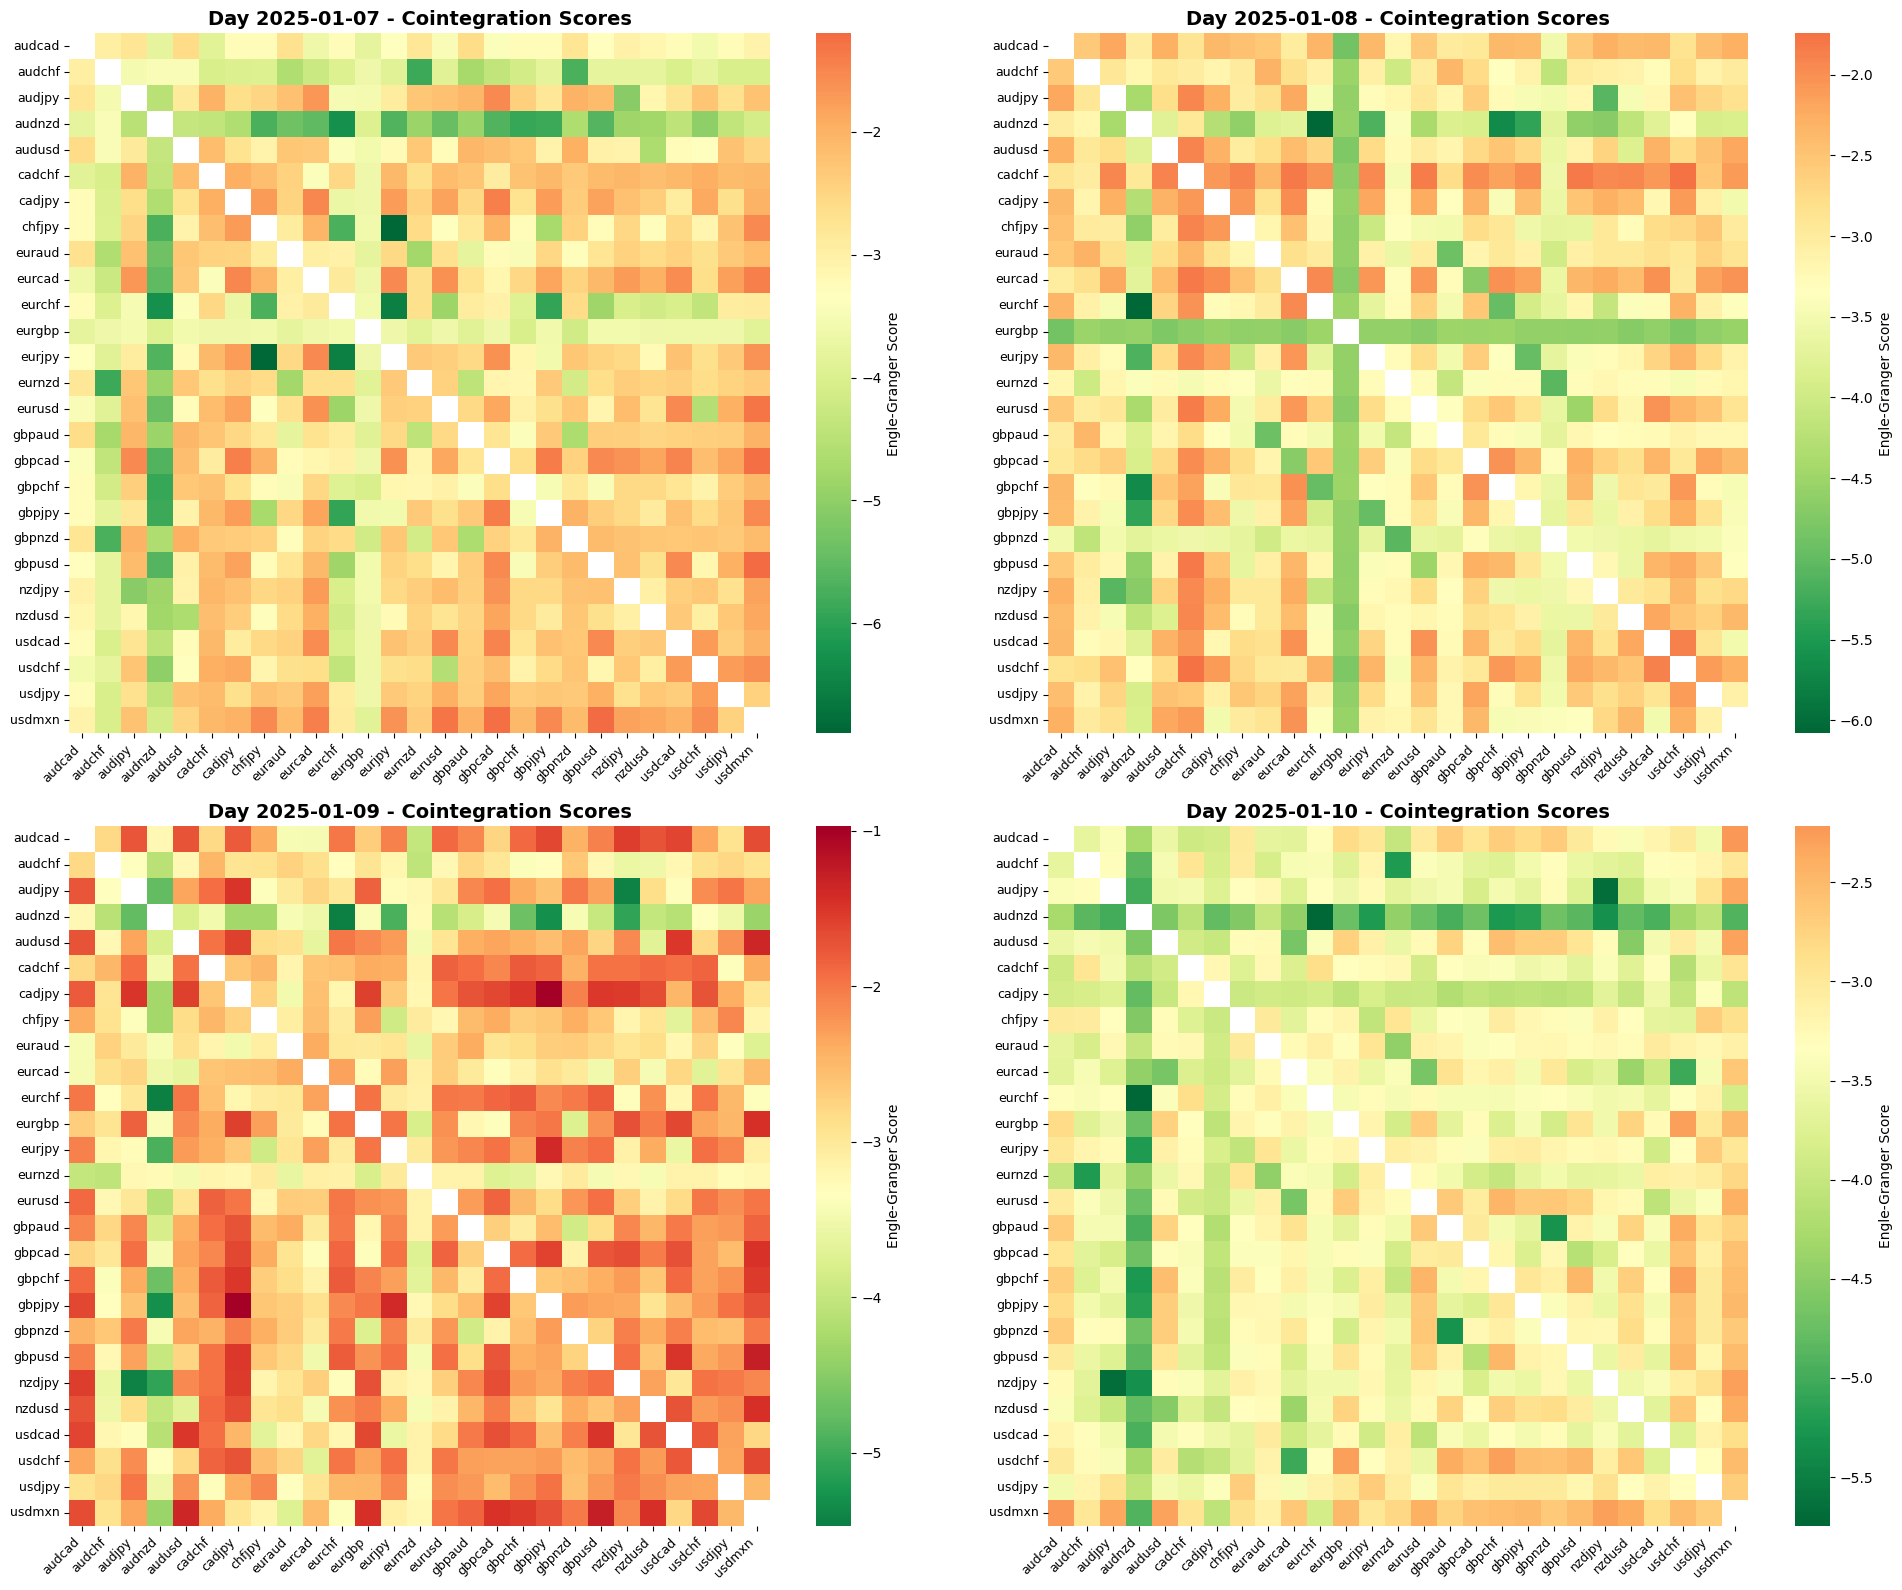

In [4]:
if daily_results is not None:
    n_days_display = min(4, len(daily_results))
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    for idx, day_data in enumerate(daily_results[:n_days_display]):
        day_key = day_data['day']
        matrix = daily_matrices[day_key]
        
        ax = axes[idx]
        sns.heatmap(matrix, 
                   xticklabels=all_pairs_sorted, 
                   yticklabels=all_pairs_sorted,
                   cmap='RdYlGn_r',
                   center=CRIT_5PCT,
                   cbar_kws={'label': 'Engle-Granger Score'},
                   ax=ax,
                   square=True)
        
        ax.set_title(f'Day {day_key} - Cointegration Scores', fontsize=14, fontweight='bold')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
        plt.setp(ax.get_yticklabels(), rotation=0, fontsize=9)
    
    plt.tight_layout()
    plt.show()

## 4️⃣ Top Cointegrated Pairs Over Time

Tracking the stability of the most significant pairs.

In [5]:
if daily_results is not None:
    # Prepare data
    top_data = []
    for day_data in daily_results:
        # Get top 5 pairs per day
        for res in day_data['results'][:5]:
            top_data.append({
                'Date': day_data['day_end'],
                'Pair': f"{res['pair1']}/{res['pair2']}",
                'Score': res['score']
            })
    
    df_top = pd.DataFrame(top_data)
    
    # Get 10 most frequent pairs in the top lists
    consistent_pairs = df_top['Pair'].value_counts().head(10).index.tolist()
    df_top_filtered = df_top[df_top['Pair'].isin(consistent_pairs)].copy()
    
    # Create 4-panel visualization avoiding overlapping
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            '① Line Plot with Markers',
            '② Scatter Plot (No Lines)',
            '③ Faceted View (One per Row)',
            '④ Box Plot by Pair'
        ),
        specs=[[{'secondary_y': False}, {'secondary_y': False}],
               [{'type': 'box'}, {'type': 'bar'}]],
        vertical_spacing=0.15,
        horizontal_spacing=0.12
    )
    
    # Panel 1: Line plot with reduced opacity
    for pair in consistent_pairs:
        pair_data = df_top_filtered[df_top_filtered['Pair'] == pair].sort_values('Date')
        fig.add_trace(
            go.Scatter(
                x=pair_data['Date'], y=pair_data['Score'],
                mode='lines+markers',
                name=pair,
                line=dict(width=1.5),
                marker=dict(size=4, opacity=0.7),
                hovertemplate='<b>%{fullData.name}</b><br>Date: %{x|%Y-%m-%d}<br>Score: %{y:.3f}',
                showlegend=False
            ),
            row=1, col=1
        )
    
    # Panel 2: Scatter plot only (time on x, score on y, color by pair)
    for pair in consistent_pairs:
        pair_data = df_top_filtered[df_top_filtered['Pair'] == pair].sort_values('Date')
        fig.add_trace(
            go.Scatter(
                x=pair_data['Date'], y=pair_data['Score'],
                mode='markers',
                name=pair,
                marker=dict(size=6, opacity=0.6),
                hovertemplate='<b>%{fullData.name}</b><br>Date: %{x|%Y-%m-%d}<br>Score: %{y:.3f}',
                showlegend=False
            ),
            row=1, col=2
        )
    
    # Panel 3: Box plot distribution by pair
    for pair in consistent_pairs:
        pair_data = df_top_filtered[df_top_filtered['Pair'] == pair]['Score']
        fig.add_trace(
            go.Box(
                y=pair_data,
                name=pair,
                boxmean='sd',
                hovertemplate='<b>%{fullData.name}</b><br>Score: %{y:.3f}',
                showlegend=False
            ),
            row=2, col=1
        )
    
    # Panel 4: Mean score by pair (with confidence visualization)
    pair_stats = df_top_filtered.groupby('Pair')['Score'].agg(['mean', 'std', 'count']).reset_index()
    pair_stats = pair_stats.sort_values('mean')
    
    fig.add_trace(
        go.Bar(
            x=pair_stats['mean'],
            y=pair_stats['Pair'],
            error_x=dict(
                type='data',
                array=pair_stats['std'],
                visible=True
            ),
            marker=dict(
                color=pair_stats['mean'],
                colorscale='RdYlGn_r',
                showscale=True,
                colorbar=dict(title="Mean Score", len=0.4, y=0.25)
            ),
            orientation='h',
            hovertemplate='<b>%{y}</b><br>Mean: %{x:.3f}<br>±Std: %{error_x.array:.3f}',
            showlegend=False,
            name='Mean Score'
        ),
        row=2, col=2
    )
    
    # Add significance lines
    fig.add_hline(y=CRIT_5PCT, line_dash="dash", line_color="red", 
                  annotation_text="5% Sig.", annotation_position="right",
                  row=1, col=1)
    fig.add_hline(y=CRIT_5PCT, line_dash="dash", line_color="red",
                  row=1, col=2)
    fig.add_vline(x=CRIT_5PCT, line_dash="dash", line_color="red",
                  annotation_text="5% Sig.", annotation_position="top",
                  row=2, col=2)
    
    # Update axes
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_yaxes(title_text="Score", row=1, col=1)
    
    fig.update_xaxes(title_text="Date", row=1, col=2)
    fig.update_yaxes(title_text="Score", row=1, col=2)
    
    fig.update_xaxes(title_text="Score", row=2, col=2)
    fig.update_yaxes(title_text="Pair", row=2, col=1)
    fig.update_yaxes(title_text="Pair", row=2, col=2)
    
    # Overall styling
    fig.update_layout(
        height=1000,
        width=1400,
        template='plotly_dark',
        title_text='<b>Top 10 Consistent Pairs (Daily Rolling 7d) - Multiple Views</b>',
        title_font_size=16,
        hovermode='closest',
        showlegend=False
    )
    
    fig.show()
    
    print(f"\n📊 Analysis Overview:")
    print(f"   Total rolling days: {len(daily_results)}")
    print(f"   Top 10 consistent pairs: {len(consistent_pairs)}")
    print(f"   Mean scores by pair:")
    for _, row in pair_stats.iterrows():
        sig = "✓" if row['mean'] < CRIT_5PCT else "✗"
        print(f"      {sig} {row['Pair']}: {row['mean']:.3f} (±{row['std']:.3f})")


📊 Analysis Overview:
   Total rolling days: 359
   Top 10 consistent pairs: 10
   Mean scores by pair:
      ✓ chfjpy/gbpjpy: -6.840 (±2.208)
      ✓ chfjpy/eurjpy: -6.255 (±1.250)
      ✓ cadchf/usdchf: -6.175 (±1.164)
      ✓ audjpy/nzdjpy: -6.160 (±1.209)
      ✓ audchf/cadchf: -6.015 (±1.063)
      ✓ audchf/euraud: -5.944 (±1.040)
      ✓ cadchf/eurcad: -5.934 (±0.980)
      ✓ cadchf/eurchf: -5.909 (±0.811)
      ✓ eurgbp/gbpchf: -5.769 (±1.196)
      ✓ eurchf/gbpchf: -5.704 (±1.230)


In [6]:
if daily_results is not None:
    # Build top-20 per day dataset
    top20_data = []
    for day_data in daily_results:
        for res in day_data['results'][:20]:
            top20_data.append({
                'Date': day_data['day_end'],
                'Pair': f"{res['pair1']}/{res['pair2']}",
                'Score': res['score']
            })

    df_top20 = pd.DataFrame(top20_data)
    consistent_pairs_20 = df_top20['Pair'].value_counts().head(20).index.tolist()
    df_top20_filtered = df_top20[df_top20['Pair'].isin(consistent_pairs_20)].copy()

    counts = df_top20_filtered['Pair'].value_counts()
    mean_scores_20 = df_top20_filtered.groupby('Pair')['Score'].mean()

    # Order by strongest (more negative score) first
    order = mean_scores_20.sort_values().index.tolist()
    consistent_pairs_20 = order
    counts = counts.reindex(order)
    mean_scores_20 = mean_scores_20.reindex(order)

    # Pair-level persistence: pct of times a top-20 pair at t remains significant at t+1 (daily)
    persistence_data = []
    for i in range(len(daily_results) - 1):
        curr_day = daily_results[i]
        next_day = daily_results[i+1]

        curr_res = {f"{r['pair1']}/{r['pair2']}": r['score'] for r in curr_day['results']}
        next_res = {f"{r['pair1']}/{r['pair2']}": r['score'] for r in next_day['results']}

        top_curr = sorted(curr_res.items(), key=lambda x: x[1])[:20]
        for pair, score_t in top_curr:
            score_t1 = next_res.get(pair, np.nan)
            persistence_data.append({
                'Pair': pair,
                'Score_t': score_t,
                'Score_t1': score_t1,
                'Still_Significant': score_t1 < CRIT_5PCT if not np.isnan(score_t1) else False
            })

    df_pers_local = pd.DataFrame(persistence_data)
    pair_persistence = df_pers_local[df_pers_local['Pair'].isin(consistent_pairs_20)].groupby('Pair')['Still_Significant'].mean() * 100
    pair_persistence = pair_persistence.reindex(order).fillna(0)

    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=(
            'Top 20 Consistent Pairs: Survival % (t → t+1 day)',
            'Average Score of Top 20 Consistent Pairs (Flipped)'
        ),
        column_widths=[0.45, 0.55]
    )

    # Persistence bar
    fig.add_trace(
        go.Bar(
            y=consistent_pairs_20,
            x=pair_persistence.values,
            orientation='h',
            marker_color='teal',
            name='Survival %'
        ),
        row=1, col=1
    )

    # Mean score bar with colorscale via marker (x-axis flipped)
    fig.add_trace(
        go.Bar(
            y=consistent_pairs_20,
            x=mean_scores_20.values,
            orientation='h',
            marker=dict(
                color=mean_scores_20.values,
                colorscale='RdYlGn_r',
                colorbar=dict(title='Mean Score', len=0.8)
            ),
            name='Avg Score',
            showlegend=False
        ),
        row=1, col=2
    )

    fig.add_vline(x=CRIT_5PCT, line_dash='dash', line_color='red', row=1, col=2)

    fig.update_layout(
        height=800,
        template='plotly_dark',
        title='Top 20 Consistent Pairs (Daily Rolling 7d) - Survival vs Mean Score',
        showlegend=False
    )
    fig.update_xaxes(title_text='Survival % (t to t+1 day)', row=1, col=1)
    fig.update_xaxes(title_text='Mean Score (lower is stronger)', row=1, col=2, autorange='reversed')
    fig.update_yaxes(title_text='Pair', row=1, col=1)
    fig.update_yaxes(title_text='', row=1, col=2)

    fig.show()

    print('Top 20 consistent pairs (by mean score order):')
    for pair, cnt, ms, surv in zip(consistent_pairs_20, counts.values, mean_scores_20.values, pair_persistence.values):
        sig = '✓' if ms < CRIT_5PCT else '✗'
        print(f'   {sig} {pair}: {cnt} days, mean score {ms:.3f}, survival {surv:.1f}%')
else:
    print('No daily_results loaded.')

Top 20 consistent pairs (by mean score order):
   ✓ chfjpy/gbpjpy: 54 days, mean score -5.765, survival 92.5%
   ✓ audjpy/nzdjpy: 129 days, mean score -5.633, survival 89.9%
   ✓ cadchf/usdchf: 89 days, mean score -5.604, survival 93.3%
   ✓ audchf/euraud: 143 days, mean score -5.560, survival 93.0%
   ✓ cadchf/eurusd: 55 days, mean score -5.498, survival 89.1%
   ✓ chfjpy/eurjpy: 74 days, mean score -5.494, survival 89.0%
   ✓ cadchf/eurcad: 134 days, mean score -5.426, survival 94.0%
   ✓ cadchf/eurchf: 85 days, mean score -5.421, survival 86.9%
   ✓ audchf/cadchf: 68 days, mean score -5.408, survival 91.2%
   ✓ eurchf/gbpchf: 75 days, mean score -5.328, survival 83.8%
   ✓ eurgbp/gbpchf: 76 days, mean score -5.291, survival 85.5%
   ✓ cadchf/eurgbp: 58 days, mean score -5.198, survival 81.0%
   ✓ audchf/nzdjpy: 57 days, mean score -5.169, survival 89.5%
   ✓ cadchf/gbpcad: 59 days, mean score -5.155, survival 88.1%
   ✓ eurusd/usdchf: 53 days, mean score -5.112, survival 84.9%
   ✓ 

## 6️⃣ Persistence Analysis (Daily, No Lookahead Bias)



This section measures how "sticky" cointegration is day-to-day. We select the best pairs at day $t$ (from the rolling 7-day window) and check if they are still cointegrated at day $t+1$.

In [7]:
if daily_results is not None:
    persistence_data = []
    
    for i in range(len(daily_results) - 1):
        curr_day = daily_results[i]
        next_day = daily_results[i+1]
        
        curr_res = {f"{r['pair1']}/{r['pair2']}": r['score'] for r in curr_day['results']}
        next_res = {f"{r['pair1']}/{r['pair2']}": r['score'] for r in next_day['results']}
        
        # Get top 20 pairs of current day
        top_curr = sorted(curr_res.items(), key=lambda x: x[1])[:20]
        
        for pair, score_t in top_curr:
            score_t1 = next_res.get(pair, np.nan)
            persistence_data.append({
                'Day_t': curr_day['day'],
                'Pair': pair,
                'Score_t': score_t,
                'Score_t1': score_t1,
                'Still_Significant': score_t1 < CRIT_5PCT if not np.isnan(score_t1) else False
            })
            
    df_pers = pd.DataFrame(persistence_data)
    
    # Calculate daily survival rate and bin it (7-day resample) for readability
    survival_rate = df_pers.groupby('Day_t')['Still_Significant'].mean() * 100
    survival_rate.index = pd.to_datetime(survival_rate.index)
    survival_rate_binned = survival_rate.resample('7D').mean()
    
    fig = make_subplots(rows=1, cols=2, 
                        subplot_titles=('Score Persistence: t vs t+1 day', 'Binned Survival Rate (7D)'))
    
    # Scatter plot: Score(t) vs Score(t+1)
    fig.add_trace(go.Scatter(x=df_pers['Score_t'], y=df_pers['Score_t1'], 
                             mode='markers', name='Pair Transition',
                             marker=dict(color='rgba(100, 200, 255, 0.6)'),
                             hovertemplate='Pair: %{text}<br>t: %{x:.2f}<br>t+1: %{y:.2f}',
                             text=df_pers['Pair']),
                  row=1, col=1)
    
    # Diagonal line (perfect persistence)
    min_val = min(df_pers['Score_t'].min(), df_pers['Score_t1'].dropna().min())
    fig.add_trace(go.Scatter(x=[min_val, CRIT_5PCT], y=[min_val, CRIT_5PCT], 
                             mode='lines', name='Perfect Persistence', 
                             line=dict(dash='dash', color='white')),
                  row=1, col=1)
    
    # Survival Rate Bar (binned)
    fig.add_trace(go.Bar(x=survival_rate_binned.index, y=survival_rate_binned.values, 
                         name='Survival Rate % (7D bins)', marker_color='teal'),
                  row=1, col=2)
    
    fig.update_layout(height=500, template='plotly_dark', showlegend=False,
                      title='Persistence Analysis (Daily Rolling 7d): Stability of Top 20 Pairs')
    fig.update_xaxes(title_text="Score at Day t", row=1, col=1)
    fig.update_yaxes(title_text="Score at Day t+1", row=1, col=1)
    fig.update_yaxes(title_text="Survival % (7D bins)", row=1, col=2)
    
    fig.show()
    print(f"✓ Mean Survival Rate of Top 20 pairs (daily): {survival_rate.mean():.2f}%")

✓ Mean Survival Rate of Top 20 pairs (daily): 81.24%


### 7️⃣ Animated Cointegration Matrix

Visualizing how the entire matrix evolves. Watch for clusters of stability.

In [8]:
if daily_results is not None:
    import plotly.express as px
    
    frames = []
    sorted_days = sorted(daily_matrices.keys())
    for day_key in sorted_days:
        frames.append(go.Frame(
            data=[go.Heatmap(
                z=daily_matrices[day_key],
                x=all_pairs_sorted,
                y=all_pairs_sorted,
                colorscale='RdYlGn_r',
                zmin=-10, zmax=0
            )],
            name=day_key
        ))
        
    fig = go.Figure(
        data=[go.Heatmap(
            z=daily_matrices[sorted_days[0]],
            x=all_pairs_sorted,
            y=all_pairs_sorted,
            colorscale='RdYlGn_r',
            zmin=-10, zmax=0
        )],
        layout=go.Layout(
            title="Evolution of Cointegration Matrix (Daily Rolling 7d)",
            updatemenus=[dict(type="buttons", buttons=[dict(label="Play", method="animate", args=[None])])]
        ),
        frames=frames
    )
    
    fig.update_layout(width=800, height=800, template='plotly_dark')
    fig.show()

## 5️⃣ 3D Evolution of Cointegration Matrix

Interactive 3D visualization of the cointegration scores over time.

- **X/Y Axes**: Currency Pairs
- **Z Axis**: Engle-Granger Score (lower is better)
- **Animation**: Play/Pause controls to see daily evolution

In [9]:
if daily_results is not None:
    # Prepare data for 3D animation
    all_scores = []
    for day_data in daily_results:
        all_scores.extend(daily_matrices[day_data['day']].flatten())
    
    # Determine Z-axis range (capped for visualization stability)
    all_scores_clean = [s for s in all_scores if not np.isnan(s)]
    z_min = max(min(all_scores_clean), -15) if all_scores_clean else -10
    z_max = min(max(all_scores_clean), 5) if all_scores_clean else 0

    # Create frames
    frames = []
    for day_data in daily_results:
        day = day_data['day']
        matrix = daily_matrices[day]
        
        frames.append(go.Frame(
            data=[go.Surface(z=matrix, x=all_pairs_sorted, y=all_pairs_sorted)],
            name=day
        ))

    # Initial plot data
    initial_day = daily_results[0]['day']
    initial_matrix = daily_matrices[initial_day]

    fig = go.Figure(
        data=[go.Surface(
            z=initial_matrix, 
            x=all_pairs_sorted, 
            y=all_pairs_sorted,
            colorscale='RdYlGn_r',
            cmin=-5, 
            cmax=-2,
            colorbar=dict(title='Score')
        )],
        frames=frames
    )

    # Layout with Play/Pause and Sliders
    fig.update_layout(
        title='3D Evolution of Cointegration Matrix',
        width=1000,
        height=900,
        scene=dict(
            xaxis=dict(title='Asset A', ticktext=all_pairs_sorted, tickvals=list(range(len(all_pairs_sorted)))),
            yaxis=dict(title='Asset B', ticktext=all_pairs_sorted, tickvals=list(range(len(all_pairs_sorted)))),
            zaxis=dict(title='Score', range=[z_min, z_max]),
            aspectratio=dict(x=1, y=1, z=0.6),
            camera=dict(eye=dict(x=1.6, y=1.6, z=1.4))
        ),
        updatemenus=[{
            'type': 'buttons',
            'showactive': False,
            'y': 0,
            'x': 0.1,
            'xanchor': 'right',
            'yanchor': 'top',
            'pad': {'t': 0, 'r': 10},
            'buttons': [
                {
                    'label': '▶ Play',
                    'method': 'animate',
                    'args': [None, {
                        'frame': {'duration': 200, 'redraw': True},
                        'fromcurrent': True,
                        'transition': {'duration': 100, 'easing': 'quadratic-in-out'}
                    }]
                },
                {
                    'label': '❚❚ Pause',
                    'method': 'animate',
                    'args': [[None], {
                        'mode': 'immediate',
                        'frame': {'duration': 0, 'redraw': False},
                        'transition': {'duration': 0}
                    }]
                }
            ]
        }],
        sliders=[{
            'currentvalue': {
                'visible': True,
                'prefix': 'Date: ',
                'xanchor': 'right',
                'font': {'size': 20, 'color': '#666'}
            },
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'y': 0,
            'steps': [
                {
                    'method': 'animate',
                    'args': [[f.name], {
                        'mode': 'immediate',
                        'frame': {'duration': 0, 'redraw': True},
                        'transition': {'duration': 0}
                    }],
                    'label': f.name
                } for f in frames
            ]
        }]
    )

    fig.show()